# **Steam data analysis**
### Data from Steam API and SteamSpy, dataset by Craig Kelly

In [4]:
import pandas as pd
import altair as alt
import numpy as np

In [29]:
alt.renderers.enable('default')
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

## **Load the datasets:**

In [35]:
cg_df = pd.read_csv('craigkelly.csv')
steamspy_df = pd.read_json('steamspy.json', orient='index').reset_index()

## **Overview the columns:**

In [36]:
print("--- CraigKelly: ---")
cg_fr = cg_df.iloc[0]
for c in cg_df.columns:
    print(c + ": " + str(fr[c]))
print("--- SteamSpy: ---")
ss_fr = steamspy_df.iloc[0]
for c in steamspy_df.columns:
    print(str(c) + ": " + str(ss_fr[c]))

--- CraigKelly: ---
QueryID: 10
ResponseID: 10
QueryName: Counter-Strike
ResponseName: Counter-Strike
ReleaseDate: Nov 1 2000
RequiredAge: 0
DemoCount: 0
DeveloperCount: 1
DLCCount: 0
Metacritic: 88
MovieCount: 0
PackageCount: 1
RecommendationCount: 68991
PublisherCount: 1
ScreenshotCount: 13
SteamSpyOwners: 13033334
SteamSpyOwnersVariance: 92789
SteamSpyPlayersEstimate: 9140731
SteamSpyPlayersVariance: 78136
AchievementCount: 0
AchievementHighlightedCount: 0
ControllerSupport: False
IsFree: False
FreeVerAvail: False
PurchaseAvail: True
SubscriptionAvail: False
PlatformWindows: True
PlatformLinux: True
PlatformMac: True
PCReqsHaveMin: True
PCReqsHaveRec: False
LinuxReqsHaveMin: True
LinuxReqsHaveRec: False
MacReqsHaveMin: True
MacReqsHaveRec: False
CategorySinglePlayer: False
CategoryMultiplayer: True
CategoryCoop: False
CategoryMMO: False
CategoryInAppPurchase: False
CategoryIncludeSrcSDK: False
CategoryIncludeLevelEditor: False
CategoryVRSupport: False
GenreIsNonGame: False
GenreIsIn

In [37]:
# https://gist.github.com/jlln/338b4b0b55bd6984f88

def splitDataFrameList(cg_df,target_column,separator):
    ''' cg_df = dataframe to split,
    target_column = the column containing the values to split
    separator = the symbol used to perform the split
    returns: a dataframe with each entry for the target column separated, with each element moved into a new row. 
    The values in the other columns are duplicated across the newly divided rows.
    '''
    def splitListToRows(row,row_accumulator,target_column,separator):
        if row[target_column] == None:
            return
        split_row = row[target_column].split(separator)
        for s in split_row:
            new_row = row.to_dict()
            new_row[target_column] = s
            row_accumulator.append(new_row)
    new_rows = []
    cg_df.apply(splitListToRows,axis=1,args = (new_rows,target_column,separator))
    new_cg_df = pd.DataFrame(new_rows)
    return new_cg_df

## **Set scale for the charts:**

In [38]:
SCALE = 1

## **Refactor the columns:**

In [39]:
category_names = cg_df.filter(regex='^category')
categories_col = []
for r in range(len(cg_df.index)):
    categories = [category.replace('category', '') for category in category_names if cg_df[category][r]]
    categories_col.append(','.join(categories) if len(categories) > 0 else None)
cg_df['categories'] = categories_col

genre_names = cg_df.filter(regex='^genreis')
genres_col = []
for r in range(len(cg_df.index)):
    genres = [genre.replace('genreis', '') for genre in genre_names if cg_df[genre][r]]
    genres_col.append(','.join(genres) if len(genres) > 0 else None)
cg_df['genres'] = genres_col

category_exploded_cg_df = splitDataFrameList(cg_df, 'categories', ',')
genre_exploded_cg_df = splitDataFrameList(cg_df, 'genres', ',')
category_genre_exploded_cg_df = splitDataFrameList(category_exploded_cg_df, 'genres', ',')

i = 0

avg_owners_col = []

for r in range(len(steamspy_df.index)):
    ownrs = steamspy_df['owners'][r].split(' .. ')
    if len(ownrs) == 2:
        ownrs = int(ownrs[0].replace(',', '')) + int(ownrs[0].replace(',', ''))
    avg_owners_col.append(ownrs)
    
steamspy_df['avg_owners'] = avg_owners_col

## **Game count by category and genre:**

In [ ]:
category_genre_count_chart = alt.Chart(category_genre_exploded_cg_df).mark_point().encode(
    x=alt.X('genres:N', axis=alt.Axis(labelAngle=-45)),
    y=alt.Y('categories:N'),
    size=alt.Size('count()', scale=alt.Scale(range=[1, 1200 * SCALE])),
    tooltip=alt.Tooltip(['count()'])
).properties(
    width=500 * SCALE,
    height=250 * SCALE
)

category_count_bars = alt.Chart(category_exploded_cg_df).mark_bar().encode(
    x=alt.X('count()'),
    y=alt.Y('categories:N', axis=None),
    tooltip=alt.Tooltip(['count()'])
).properties(
    width=200 * SCALE,
    height=250 * SCALE
)

genre_count_bars = alt.Chart(genre_exploded_cg_df).mark_bar().encode(
    x=alt.X('genres:N', axis=None),
    y=alt.Y('count()'),
    tooltip=alt.Tooltip(['count()'])
).properties(
    width=500 * SCALE,
    height=200 * SCALE
)

genre_count_bars & (category_genre_count_chart | category_count_bars)

## **Owner count by category and genre:**

In [ ]:
category_genre_owner_chart = alt.Chart(category_genre_exploded_cg_df).mark_point().encode(
    x=alt.X('genres:N', axis=alt.Axis(labelAngle=-45)),
    y=alt.Y('categories:N'),
    size=alt.Size('sum(steamspyowners)', scale=alt.Scale(range=[1, 1200 * SCALE])),
    tooltip=alt.Tooltip(['sum(steamspyowners)'])
).properties(
    width=500 * SCALE,
    height=250 * SCALE
)

category_owner_bars = alt.Chart(category_exploded_cg_df).mark_bar().encode(
    x=alt.X('sum(steamspyowners)'),
    y=alt.Y('categories:N', axis=None),
    tooltip=alt.Tooltip(['sum(steamspyowners)'])
).properties(
    width=200 * SCALE,
    height=250 * SCALE
)

genre_owner_bars = alt.Chart(genre_exploded_cg_df).mark_bar().encode(
    x=alt.X('genres:N', axis=None),
    y=alt.Y('sum(steamspyowners)'),
    tooltip=alt.Tooltip(['sum(steamspyowners)'])
).properties(
    width=500 * SCALE,
    height=200 * SCALE
)

genre_owner_bars & (category_genre_owner_chart | category_owner_bars)

## **Price vs owner count:**
### Can't really get the log scale to work correctly, and linear scale is useless in this case

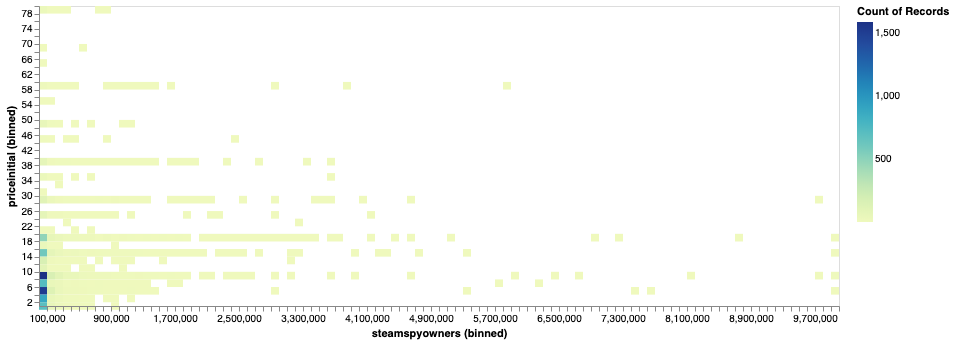

In [28]:
owners_upper = 10000000 #cg_df['steamspyowners'].max()
price_upper = 80 #cg_df['priceinitial'].max()

alt.Chart(cg_df).transform_filter(
    (alt.datum.priceinitial > 0) & (alt.datum.steamspyowners > 0)
).mark_rect().encode(
    x=alt.X(
        'steamspyowners:Q',
        bin=alt.Bin(maxbins=100, extent=[1, owners_upper]),
        scale=alt.Scale(zero=False, domain=[1, owners_upper])
#         scale=alt.Scale(type='log', base=10, domain=[100, cg_df['steamspyowners'].max()])
    ),
    y=alt.Y(
        'priceinitial:Q', 
        bin=alt.Bin(maxbins=40, extent=[1, price_upper]),
        scale=alt.Scale(zero=False, domain=[1, price_upper])
        #scale=alt.Scale(type='log', base=10, domain=[1, cg_df['priceinitial'].max()])
    ),
    color=alt.Color('count():Q'),
).properties(
    width=800 * SCALE
)

## **Owner count vs. Player count:**

In [21]:
degree_list = [1, 3, 5]

owner_player_scatter = alt.Chart(steamspy_df).transform_filter(
    (alt.datum.steamspyplayersestimate > 0) & (alt.datum.steamspyowners > 0)
).mark_circle().encode(
    x=alt.X(
        'steamspyowners:Q',
#         scale=alt.Scale(type='log', base=10)
    ),
    y=alt.Y(
        'steamspyplayersestimate:Q',
#         scale=alt.Scale(type='log', base=10)
    ),
).properties(
    width=800 * SCALE,
    height=500 * SCALE
)

owner_player_polynomial_fits = [
    owner_player_scatter.transform_regression(
        'x', 'y', method='poly', order=order, as_=['x', str(order)]
    ).mark_line()
    .transform_fold([str(order)], as_=['degree', 'y'])
    .encode(alt.Color('degree:N'))
    for order in degree_list
]

# alt.layer(owner_player_scatter, *owner_player_polynomial_fits).configure_mark(
#     opacity = .1
# )
owner_player_scatter & owner_player_polynomial_fits[1]

alt.VConcatChart(...)

## **Mean Metacritic score by genre:**

## **Correlation between score and owner count:**

## **Correlation between score and player count:**

## **Correlation between price and owner count:**